In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List, Any
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import json
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
llm_key = os.getenv('llm_key')

model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    api_key=llm_key,
    base_url="https://openrouter.ai/api/v1",
    temperature=0.7
)

In [3]:
class GraphState(TypedDict):
    user_request: str
    workflow_analysis: Dict[str, Any]
    approval_chain: List[Dict[str, Any]]
    clarifying_questions: List[Dict[str, Any]]
    user_answers: Dict[str, Any]
    validation_result: Dict[str, Any]
    question_iteration: int
    form_schema: Dict[str, Any]
    excel_schema: Dict[str, Any]
    workflow: Dict[str, Any]
    master_json: Dict[str, Any]
    sanity_check: Dict[str, Any]
    sanity_issues: List[str]
    regeneration_count: int

In [4]:
def analyze_request(state: GraphState):
    """
    Initial analysis and parse structured user input
    """
    
    lines = state['user_request'].strip().split('\n')
    workflow_title = lines[0].strip() if len(lines) > 0 else "University Workflow"
    
    # Parse approval chain
    approval_sequence = []
    if len(lines) > 1:
        chain_line = lines[1].strip().lower()
        parts = [p.strip() for p in chain_line.replace(' to ', '|').split('|')]
        approval_sequence = [p for p in parts if p and p != 'student']
    
    # Parse additional requirements
    additional_reqs = []
    if len(lines) > 2:
        additional_reqs = [line.strip() for line in lines[2:] if line.strip()]
    
    # Build approval chain
    approval_chain = []
    for idx, role in enumerate(approval_sequence, 1):
        role_title = role.title()
        rejection_behavior = "end_workflow"
        notification_rules = []
        
        for req in additional_reqs:
            if "reject" in req.lower() and "director" in req.lower():
                notification_rules.append("notify director on rejection")
                rejection_behavior = "notify_director"
        
        approval_chain.append({
            "level": idx,
            "approver_role": role_title,
            "approver_type": "single",
            "source": "from_form",
            "conditions": [f"Level {idx} approver", "Can approve/reject with comments"],
            "rejection_behavior": rejection_behavior,
            "notification_rules": notification_rules,
            "timeout_hours": 48
        })
    
    # Basic analysis
    analysis = {
        "workflow_title": workflow_title,
        "approval_sequence": approval_sequence,
        "additional_requirements": additional_reqs,
        "approval_chain": approval_chain
    }
    
    print("\n🔍 INITIAL ANALYSIS COMPLETE")
    print(f"   Workflow: {workflow_title}")
    print(f"   Approval Chain: {' → '.join([r.title() for r in approval_sequence])}")
    
    return {
        "workflow_analysis": analysis,
        "approval_chain": approval_chain,
        "question_iteration": 0
    }


def generate_clarifying_questions(state: GraphState):
    """
    Use LLM to generate clarifying questions about the workflow
    """
    
    analysis = state.get("workflow_analysis", {})
    workflow_title = analysis.get("workflow_title", "")
    approval_chain = state.get("approval_chain", [])
    previous_answers = state.get("user_answers", {})
    
    print("\n🤖 LLM is generating clarifying questions...")
    
    prompt = f"""
You are a workflow design expert helping to create a Microsoft 365 automated workflow.

WORKFLOW INFORMATION:
- Title: {workflow_title}
- Approval Chain: {' → '.join([a['approver_role'] for a in approval_chain])}
- Requirements: {', '.join(analysis.get('additional_requirements', []))}

Previous Answers (if any): {json.dumps(previous_answers, indent=2) if previous_answers else "None"}

Generate 3-5 SPECIFIC clarifying questions to fully understand this workflow. Focus on:
1. What information should end users provide in the form?
2. Any special validation rules or constraints?
3. What happens in edge cases (withdrawal, timeout, etc.)?
4. Document requirements (if any)?
5. Special notification requirements?

Return ONLY valid JSON in this format:
{{
  "questions": [
    {{
      "id": "q1",
      "question": "What specific information should students provide about their leave (dates, reason, duration)?",
      "category": "form_fields",
      "required": true
    }},
    {{
      "id": "q2",
      "question": "Should there be a maximum leave duration limit?",
      "category": "business_rules",
      "required": false
    }}
  ]
}}

Return ONLY the JSON, no other text.
"""

    try:
        messages = [
            SystemMessage(content="You are a workflow design assistant. Always respond with valid JSON only."),
            HumanMessage(content=prompt)
        ]
        
        response = model.invoke(messages)
        response_text = response.content.strip()
        
        # Clean response
        if response_text.startswith("```json"):
            response_text = response_text.replace("```json", "").replace("```", "").strip()
        
        questions_data = json.loads(response_text)
        questions = questions_data.get("questions", [])
        
        print(f"\n📋 Generated {len(questions)} questions")
        
        return {
            "clarifying_questions": questions,
            "question_iteration": state.get("question_iteration", 0) + 1
        }
        
    except Exception as e:
        print(f"\n⚠️  LLM question generation failed: {e}")
        # Fallback questions
        fallback_questions = [
            {
                "id": "q1",
                "question": "What information should end users provide in the submission form?",
                "category": "form_fields",
                "required": True
            },
            {
                "id": "q2",
                "question": "Are there any document upload requirements?",
                "category": "documents",
                "required": False
            },
            {
                "id": "q3",
                "question": "Should there be any time limits or deadlines?",
                "category": "business_rules",
                "required": False
            }
        ]
        
        return {
            "clarifying_questions": fallback_questions,
            "question_iteration": state.get("question_iteration", 0) + 1
        }


def collect_user_answers(state: GraphState):
    """
    Collect answers from user for clarifying questions
    """
    
    questions = state.get("clarifying_questions", [])
    existing_answers = state.get("user_answers", {})
    
    print(f"\n{'='*80}")
    print("📝 CLARIFYING QUESTIONS")
    print(f"{'='*80}\n")
    
    print("Please answer the following to help design your workflow:\n")
    
    answers = existing_answers.copy()
    
    for question in questions:
        q_id = question["id"]
        q_text = question["question"]
        required = question.get("required", False)
        
        # Skip if already answered
        if q_id in answers and answers[q_id]:
            continue
        
        print(f"{'='*80}")
        print(f"Question {q_id.upper()}: {q_text}")
        if required:
            print("(Required)")
        else:
            print("(Optional - press Enter to skip)")
        print(f"{'='*80}")
        
        answer = input("\nYour answer: ").strip()
        
        if answer or not required:
            answers[q_id] = answer
        elif required and not answer:
            print("⚠️  This question is required. Please provide an answer.")
            answer = input("Your answer: ").strip()
            answers[q_id] = answer
    
    print(f"\n{'='*80}")
    print("✅ Answers collected")
    print(f"{'='*80}\n")
    
    return {"user_answers": answers}


def validate_user_answers(state: GraphState):
    """
    Use LLM to validate if answers are sufficient
    """
    
    questions = state.get("clarifying_questions", [])
    answers = state.get("user_answers", {})
    workflow_analysis = state.get("workflow_analysis", {})
    
    print("\n🤖 LLM is validating your answers...")
    
    prompt = f"""
You are validating user responses for workflow design.

WORKFLOW: {workflow_analysis.get('workflow_title', '')}

QUESTIONS ASKED:
{json.dumps(questions, indent=2)}

USER ANSWERS:
{json.dumps(answers, indent=2)}

Validate if the answers are sufficient to proceed with workflow generation. Check:
1. Are required questions answered?
2. Are answers clear and specific enough?
3. Are there any contradictions?
4. Is any critical information missing?

Return ONLY valid JSON:
{{
  "valid": true/false,
  "missing_info": ["list of missing information"],
  "follow_up_needed": ["list of areas needing clarification"],
  "can_proceed": true/false
}}

Return ONLY the JSON, no other text.
"""

    try:
        messages = [
            SystemMessage(content="You are a validation assistant. Always respond with valid JSON only."),
            HumanMessage(content=prompt)
        ]
        
        response = model.invoke(messages)
        response_text = response.content.strip()
        
        # Clean response
        if response_text.startswith("```json"):
            response_text = response_text.replace("```json", "").replace("```", "").strip()
        
        validation = json.loads(response_text)
        
        if validation.get("valid") and validation.get("can_proceed"):
            print("   ✅ Validation passed - proceeding to generation")
        else:
            print("   ⚠️  More information needed")
            if validation.get("missing_info"):
                print(f"   Missing: {', '.join(validation['missing_info'])}")
        
        return {"validation_result": validation}
        
    except Exception as e:
        print(f"\n⚠️  Validation failed: {e}")
        # Default to valid if LLM fails
        return {
            "validation_result": {
                "valid": True,
                "can_proceed": True,
                "missing_info": [],
                "follow_up_needed": []
            }
        }


def enrich_workflow_analysis(state: GraphState):
    """
    Use LLM to enrich workflow analysis with user answers
    """
    
    initial_analysis = state.get("workflow_analysis", {})
    user_answers = state.get("user_answers", {})
    approval_chain = state.get("approval_chain", [])
    
    print("\n🤖 LLM is enriching workflow analysis...")
    
    prompt = f"""
You are a workflow architect. Based on the user's answers, create a comprehensive workflow specification.

INITIAL ANALYSIS:
{json.dumps(initial_analysis, indent=2)}

APPROVAL CHAIN:
{json.dumps(approval_chain, indent=2)}

USER ANSWERS:
{json.dumps(user_answers, indent=2)}

Generate a complete workflow specification in VALID JSON format:
{{
  "workflow_name": "Workflow Title",
  "workflow_description": "Detailed description",
  "data_to_collect": [
    {{
      "field_name": "submitter_name",
      "label": "Your Full Name",
      "type": "text",
      "required": true,
      "validation": "string",
      "purpose": "identification"
    }}
  ],
  "business_rules": ["list of rules"],
  "notifications": [
    {{
      "trigger": "form_submitted",
      "recipients": ["submitter", "first_approver"],
      "platform": "Outlook",
      "template": "confirmation"
    }}
  ],
  "special_requirements": ["any special requirements from answers"]
}}

Include all necessary form fields based on user answers. Return ONLY valid JSON.
"""

    try:
        messages = [
            SystemMessage(content="You are a workflow specification generator. Always return valid JSON only."),
            HumanMessage(content=prompt)
        ]
        
        response = model.invoke(messages)
        response_text = response.content.strip()
        
        # Clean response
        if response_text.startswith("```json"):
            response_text = response_text.replace("```json", "").replace("```", "").strip()
        
        enriched_analysis = json.loads(response_text)
        
        # Merge with existing analysis
        enriched_analysis["approval_chain"] = approval_chain
        enriched_analysis["platform_requirements"] = {
            "form_platform": "Microsoft Forms",
            "tracking_platform": "Excel Online (Business)",
            "approval_platform": "Microsoft Teams - Approvals",
            "email_platform": "Office 365 Outlook"
        }
        
        print("   ✅ Workflow analysis enriched")
        
        return {"workflow_analysis": enriched_analysis}
        
    except Exception as e:
        print(f"\n⚠️  Enrichment failed: {e}, using basic analysis")
        # Return basic structure
        return {
            "workflow_analysis": {
                **initial_analysis,
                "data_to_collect": [
                    {"field_name": "submitter_name", "label": "Your Full Name", "type": "text", "required": True},
                    {"field_name": "submitter_email", "label": "Your Email", "type": "email", "required": True},
                    {"field_name": "request_details", "label": "Request Details", "type": "textarea", "required": True}
                ],
                "business_rules": [],
                "notifications": []
            }
        }


def generate_form_schema(state: GraphState):
    """
    Generate Microsoft Forms schema
    """
    
    analysis = state.get("workflow_analysis", {})
    data_fields = analysis.get("data_to_collect", [])
    approval_chain = state.get("approval_chain", [])
    
    form_schema = {
        "title": analysis.get("workflow_name", "Workflow Form"),
        "description": analysis.get("workflow_description", ""),
        "platform": "Microsoft Forms",
        "settings": {
            "one_response_per_user": True,
            "allow_anonymous": False,
            "confirmation_message": "Your request has been submitted successfully!"
        },
        "questions": []
    }
    
    # Add user-specified fields
    for idx, field in enumerate(data_fields, 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "field_name": field["field_name"],
            "type": field["type"],
            "title": field["label"],
            "required": field.get("required", True),
            "validation": field.get("validation", ""),
            "purpose": field.get("purpose", "user_data")
        })
    
    # Add approver fields
    question_num = len(form_schema["questions"]) + 1
    for approver in approval_chain:
        role = approver["approver_role"].replace(" ", "_").lower()
        form_schema["questions"].extend([
            {
                "id": f"q{question_num}",
                "field_name": f"{role}_name",
                "type": "text",
                "title": f"{approver['approver_role']} Name",
                "required": True,
                "purpose": "approver_identification"
            },
            {
                "id": f"q{question_num + 1}",
                "field_name": f"{role}_email",
                "type": "email",
                "title": f"{approver['approver_role']} Email",
                "required": True,
                "purpose": "approver_contact"
            }
        ])
        question_num += 2
    
    print(f"\n📋 Form Schema: {len(form_schema['questions'])} questions")
    
    return {"form_schema": form_schema}


def generate_excel_schema(state: GraphState):
    """
    Generate Excel tracking schema
    """
    
    analysis = state.get("workflow_analysis", {})
    approval_chain = state.get("approval_chain", [])
    form_schema = state.get("form_schema", {})
    
    columns = [
        {"name": "SubmissionID", "type": "text"},
        {"name": "SubmissionTimestamp", "type": "datetime"},
        {"name": "CurrentStatus", "type": "choice", "choices": ["Submitted", "Pending", "Approved", "Rejected"]}
    ]
    
    # Add form fields
    for question in form_schema.get("questions", []):
        if question.get("purpose") not in ["approver_identification", "approver_contact"]:
            columns.append({
                "name": question["field_name"],
                "type": "text"
            })
    
    # Add approval tracking
    for approver in approval_chain:
        role = approver["approver_role"].replace(" ", "_")
        columns.extend([
            {"name": f"{role}_Status", "type": "choice", "choices": ["Pending", "Approved", "Rejected"]},
            {"name": f"{role}_Name", "type": "text"},
            {"name": f"{role}_Timestamp", "type": "datetime"},
            {"name": f"{role}_Comments", "type": "text"}
        ])
    
    columns.extend([
        {"name": "FinalDecision", "type": "choice", "choices": ["Approved", "Rejected"]},
        {"name": "FinalDecisionDate", "type": "datetime"}
    ])
    
    excel_schema = {
        "table_name": f"{analysis.get('workflow_name', '').replace(' ', '_')}_Tracker",
        "platform": "Excel Online (Business)",
        "location": "SharePoint/Shared Documents",
        "columns": columns
    }
    
    print(f"\n📊 Excel Schema: {len(columns)} columns")
    
    return {"excel_schema": excel_schema}


def generate_workflow(state: GraphState):
    """
    Generate Power Automate workflow
    """
    
    analysis = state.get("workflow_analysis", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    approval_chain = state.get("approval_chain", [])
    
    workflow = {
        "name": analysis.get("workflow_name", ""),
        "description": analysis.get("workflow_description", ""),
        "platform": "Microsoft Power Automate",
        "trigger": {
            "type": "Microsoft Forms",
            "operation": "When a new response is submitted",
            "form_name": form_schema.get("title", "")
        },
        "steps": []
    }
    
    step_num = 1
    
    # Get form response
    workflow["steps"].append({
        "step_number": step_num,
        "name": "Get Form Response",
        "type": "Microsoft Forms - Get response details",
        "connector": "Microsoft Forms"
    })
    step_num += 1
    
    # Create Excel row
    workflow["steps"].append({
        "step_number": step_num,
        "name": "Create Excel Tracking Row",
        "type": "Excel Online - Add row",
        "connector": "Excel Online (Business)"
    })
    step_num += 1
    
    # Send confirmation
    workflow["steps"].append({
        "step_number": step_num,
        "name": "Send Confirmation Email",
        "type": "Outlook - Send email",
        "connector": "Office 365 Outlook"
    })
    step_num += 1
    
    # Approval flow
    for approver in approval_chain:
        workflow["steps"].append({
            "step_number": step_num,
            "name": f"Approval - {approver['approver_role']}",
            "type": "Teams - Start approval",
            "connector": "Microsoft Teams Approvals",
            "level": approver["level"]
        })
        step_num += 1
        
        workflow["steps"].append({
            "step_number": step_num,
            "name": f"Update Excel - {approver['approver_role']}",
            "type": "Excel Online - Update row",
            "connector": "Excel Online (Business)"
        })
        step_num += 1
    
    # Final notification
    workflow["steps"].append({
        "step_number": step_num,
        "name": "Send Final Notification",
        "type": "Outlook - Send email",
        "connector": "Office 365 Outlook"
    })
    
    print(f"\n⚙️  Workflow: {len(workflow['steps'])} steps")
    
    return {"workflow": workflow}


def generate_master_json(state: GraphState):
    """
    Create master JSON output
    """
    
    analysis = state.get("workflow_analysis", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    workflow = state.get("workflow", {})
    user_answers = state.get("user_answers", {})
    
    master_json = {
        "metadata": {
            "workflow_name": analysis.get("workflow_name", ""),
            "description": analysis.get("workflow_description", ""),
            "version": "1.0",
            "generated_with": "LLM-Enhanced Workflow Generator",
            "platform": "Microsoft 365"
        },
        "user_requirements": {
            "questions_answered": user_answers
        },
        "workflow_analysis": {
            "approval_chain": state.get("approval_chain", []),
            "business_rules": analysis.get("business_rules", []),
            "notifications": analysis.get("notifications", [])
        },
        "microsoft_forms": form_schema,
        "excel_tracker": excel_schema,
        "power_automate_workflow": workflow
    }
    
    print("\n✅ Master JSON generated")
    
    return {"master_json": master_json}


def display_output(state: GraphState):
    """
    Display master JSON
    """
    
    master_json = state.get("master_json", {})
    
    print("\n" + "="*80)
    print("✅ WORKFLOW GENERATION COMPLETE")
    print("="*80)
    
    metadata = master_json.get("metadata", {})
    print(f"\n📋 {metadata.get('workflow_name', '')}")
    print(f"📝 {metadata.get('description', '')}")
    
    print("\n📄 MASTER JSON OUTPUT:")
    print("="*80 + "\n")
    
    print(json.dumps(master_json, indent=2))
    
    print("\n" + "="*80)
    
    return state


# ============================================================================
# ROUTING FUNCTIONS
# ============================================================================

def should_ask_more_questions(state: GraphState) -> str:
    """
    Decide if more questions needed
    """
    validation = state.get("validation_result", {})
    iteration = state.get("question_iteration", 0)
    
    if validation.get("can_proceed", True):
        print("\n✅ Sufficient information collected")
        return "proceed"
    elif iteration >= 2:
        print("\n⚠️  Max question iterations reached, proceeding anyway")
        return "proceed"
    else:
        print("\n🔄 Need more information...")
        return "ask_more"


# ============================================================================
# GRAPH CONSTRUCTION
# ============================================================================

def build_workflow_graph():
    """
    Build graph with question-answer loop
    """
    
    graph = StateGraph(GraphState)
    
    # Add nodes
    graph.add_node("analyze", analyze_request)
    graph.add_node("generate_questions", generate_clarifying_questions)
    graph.add_node("collect_answers", collect_user_answers)
    graph.add_node("validate_answers", validate_user_answers)
    graph.add_node("enrich_analysis", enrich_workflow_analysis)
    graph.add_node("generate_form", generate_form_schema)
    graph.add_node("generate_excel", generate_excel_schema)
    graph.add_node("generate_workflow", generate_workflow)
    graph.add_node("create_master", generate_master_json)
    graph.add_node("display", display_output)
    
    # Define flow
    graph.set_entry_point("analyze")
    graph.add_edge("analyze", "generate_questions")
    graph.add_edge("generate_questions", "collect_answers")
    graph.add_edge("collect_answers", "validate_answers")
    
    # Conditional: ask more or proceed
    graph.add_conditional_edges(
        "validate_answers",
        should_ask_more_questions,
        {
            "ask_more": "generate_questions",
            "proceed": "enrich_analysis"
        }
    )
    
    graph.add_edge("enrich_analysis", "generate_form")
    graph.add_edge("generate_form", "generate_excel")
    graph.add_edge("generate_excel", "generate_workflow")
    graph.add_edge("generate_workflow", "create_master")
    graph.add_edge("create_master", "display")
    graph.add_edge("display", END)
    
    return graph.compile()

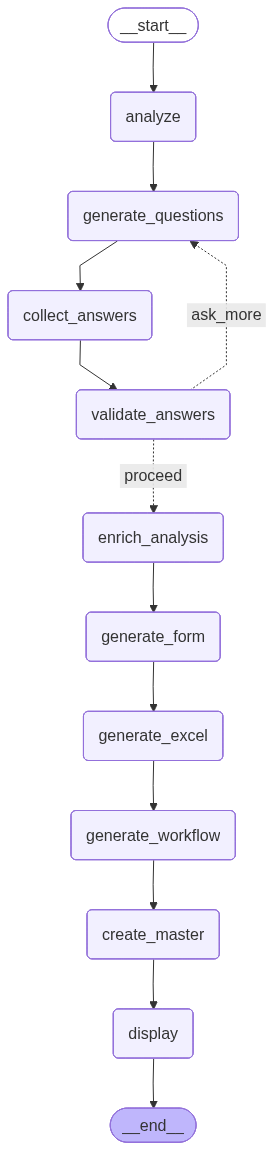

In [5]:
app = build_workflow_graph()
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:

user_input = """Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student provides all approver emails.
Director notified on rejection."""
    
print("\n" + "="*80)
print("🚀 Starting interactive workflow generation...")
print("="*80)

initial_state = {
    "user_request": user_input,
    "workflow_analysis": {},
    "approval_chain": [],
    "clarifying_questions": [],
    "user_answers": {},
    "validation_result": {},
    "question_iteration": 0,
    "form_schema": {},
    "excel_schema": {},
    "workflow": {},
    "master_json": {},
    "sanity_check": {},
    "sanity_issues": [],
    "regeneration_count": 0
}

app = build_workflow_graph()

try:
    final_state = app.invoke(initial_state)
    print("\n✅ Generation complete!")
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    import traceback
    traceback.print_exc()


🚀 Starting interactive workflow generation...

🔍 INITIAL ANALYSIS COMPLETE
   Workflow: Leave Letter Approval
   Approval Chain: 

🤖 LLM is generating clarifying questions...

📋 Generated 5 questions

📝 CLARIFYING QUESTIONS

Please answer the following to help design your workflow:

Question Q1: What specific information should students provide about their leave (dates, reason, duration)?
(Required)
Question Q2: Should there be a maximum leave duration limit?
(Optional - press Enter to skip)
Question Q3: What should happen if a mentor or class teacher does not respond within a certain timeframe?
(Required)
⚠️  This question is required. Please provide an answer.
Question Q4: Are there any specific documents that need to be submitted along with the leave request?
(Optional - press Enter to skip)
Question Q5: What specific notification should be sent to the director in case of a rejection?
(Required)

✅ Answers collected


🤖 LLM is validating your answers...
   ✅ Validation passed - pro